**Description:** This notebook is used for inference/generation of spans in a setting where generation lengths are predicted from the encoder output and the predicted length is used for length control. Some crucial details are:

1. The current model loaded is trained in Dominant spans only
2. introduction of the current paper is not included in the input
3. This model generated the span and not the paragraph
4. The log length is predicted

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
import re
import inspect

In [4]:
sys.path.append("../scripts/")

In [5]:
import json
from random import sample

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 8)
sns.set()
import numpy as np
import pandas as pd

In [8]:
from transformers.models.led.modeling_led import LEDModel

In [9]:
from tqdm import tqdm
import torch
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from dataset import CitationTextGenerationDataset, CitationParagraphGenerationDataset
from torch.utils.data import Dataset, DataLoader
from transformers import Seq2SeqTrainer

In [13]:
from nltk import sent_tokenize

In [28]:
import util
# import analysis_utils
# from modelling_led_multitask import LEDForConditionalGenerationMultipleLengthPredictor as LEDForConditionalGeneration
from modelling_led import LEDForConditionalGeneration

In [29]:
device = "cpu"

In [30]:
max_input_length = 16384
max_output_length = 1024

In [31]:
def process_data_to_model_inputs(batch, special_tokens=None, length=None, classification=False):
    # tokenize the inputs and labels
    if special_tokens is None:
        special_tokens = ['[Dominant]', '[Reference]']
    
    additional_special_tokens_lookup = {token: idx for token, idx in zip(tokenizer.additional_special_tokens, tokenizer.additional_special_tokens_ids)}
    special_token_ids = set([additional_special_tokens_lookup[token] for token in special_tokens])
    special_token_ids.add(tokenizer.mask_token_id)
    
    inputs = tokenizer(
        batch["source"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
        add_special_tokens=True 
    )
    outputs = tokenizer(
        batch["target"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
        add_special_tokens=True 
    )
    
    batch["citation_types"] = [int("[Dominant]" in x) for x in batch["source"]]

    if length:
        batch["length"] = length
    else:
        batch["length"] = [sum(x) for x in outputs.attention_mask]


    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    for i_batch in range(len(batch["input_ids"])):
        for i_token in range(len(batch["input_ids"][0])):
            if batch["input_ids"][i_batch][i_token] in special_token_ids:
                batch["global_attention_mask"][i_batch][i_token] = 1
    
    # setting [CLS] token as global attention token for classification
    if classification:
        batch["global_attention_mask"][i_batch][0] = 1
            
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]
    return batch

In [32]:
def get_context(source):
    return source.split("\n\n")[0]

In [33]:
def get_cited_paper(source):
    return source.split("\n\n")[1]

In [37]:
path = "/Users/biswadipmandal/Documents/MSCS/Research/CORWA_models/Dominant_only/length_control/span_v1/checkpoint-69500"

In [38]:
tokenizer = AutoTokenizer.from_pretrained(path)
special_tokens = ['<doc>','</doc>', '[BOS]', '[Dominant]', '[Reference]', '[B_Dominant]',  '[E_Dominant]', '[B_Reference]', '[E_Reference]']
additional_special_tokens = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(additional_special_tokens)

0

In [39]:
model = LEDForConditionalGeneration.from_pretrained(
    path
)

Some weights of the model checkpoint at /Users/biswadipmandal/Documents/MSCS/Research/CORWA_models/Dominant_only/length_control/span_v1/checkpoint-69500 were not used when initializing LEDForConditionalGeneration: ['sigma_generation', 'lm_length.2.bias', 'lm_length.0.bias', 'lm_length.2.weight', 'sigma_length', 'lm_length.0.weight']
- This IS expected if you are initializing LEDForConditionalGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LEDForConditionalGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
model.config.add_perturbation = False
model.config.predict_log_length

True

In [27]:
model = model.to(device).half()
model.eval()

LEDForConditionalGeneration(
  (led): LEDModel(
    (shared): Embedding(50274, 768, padding_idx=1)
    (encoder): LEDEncoder(
      (embed_tokens): Embedding(50274, 768, padding_idx=1)
      (embed_positions): LEDLearnedPositionalEmbedding(16384, 768)
      (layers): ModuleList(
        (0): LEDEncoderLayer(
          (self_attn): LEDEncoderAttention(
            (longformer_self_attn): LEDEncoderSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Linear(in_features=768, out_features=768, bias=True)
          )
          (

In [22]:
val_set = CitationTextGenerationDataset(
    "/home/data/XiangciLi/CORWA/annotated_test/", 
    tokenizer, 
    MAX_SENT_LEN = max_input_length,
    related_work_path='/home/data/XiangciLi/20200705v1/acl/selected_related_work.jsonl',
    cited_metadata_path='/home/data/XiangciLi/20200705v1/acl/selected_cited_metadata.jsonl',
    cited_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_cited_pdf_parses.jsonl",
    citing_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_pdf_parses.jsonl",
    skip_no_citations = True,
    include_intro=False,
)

100%|██████████| 362/362 [00:09<00:00, 37.79it/s]


In [23]:
val_set.filter_citation_type(citation_type="Dominant")

In [24]:
def run_model(batch, model):
    processed_batch = process_data_to_model_inputs(batch, special_tokens=['[Dominant]', '[Reference]'])
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    predicted_abstract_ids = model.generate(
        processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"]
    )
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=False)
    target = batch["target"]
    return out, target

In [25]:
def get_citations(src):
    """Get citations given source content"""
    all_citations = []
    for cite_data in src.split("[B_Reference]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())

    for cite_data in src.split("[B_Dominant]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())
    
    return all_citations

In [55]:
accumulated_data = []
for batch in tqdm(DataLoader(val_set, batch_size = 1, shuffle=False)):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=['[Dominant]', '[Reference]'], 
        classification=True
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    model_kwargs = {'decoder_length' : processed_batch_cuda["length"].unsqueeze(0)}

    predicted_abstract_ids = model.generate(
        input_ids = processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        **model_kwargs
    )
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    target = batch["target"]
    for o, t, part_id, source in zip(out, target, batch["id"], batch["source"]):
        accumulated_data.append(
            {"source": source, "target": t, 
             "generated": o, "part_id": part_id}
        )

  0%|          | 0/1322 [00:00<?, ?it/s]/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 1322/1322 [1:42:41<00:00,  4.66s/it] 


### Save Generations

In [47]:
analysis_utils.write_json(
    accumulated_data,  
    os.path.abspath(os.path.join(path, "../sample_output.json"))
)

In [219]:
accumulated_data = analysis_utils.load_json(
    os.path.abspath(os.path.join(path, "../sample_output.json"))
)

In [221]:
# accumulated_data[0]

In [222]:
sep_tokens = ["<s>", "</s>"]
for index, data in enumerate(accumulated_data):
    for token in sep_tokens:
        data["generated"] = data["generated"].replace(token, "").strip()
    

In [223]:
path

'/home/bxm200000/models/dominant_only/length_control/span_v1_cdlm/checkpoint-69500/'

In [147]:
# val_set[0]

In [36]:
# LENGTH PREDICTION
length_data = []
for batch in tqdm(DataLoader(val_set, batch_size = 1, shuffle=False)):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=None, 
        classification=True
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    model_kwargs = {'decoder_length' : processed_batch_cuda["length"].unsqueeze(0)}

    
    cls_encoder = model.led.encoder(
        input_ids=processed_batch_cuda["input_ids"],
        attention_mask=processed_batch_cuda["attention_mask"],
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        return_dict=True
    )[0][:,0,:]
    
    if model.config.predict_log_length:
        length_pred = torch.exp(model.lm_length(cls_encoder))
    else:
        length_pred = model.lm_length(cls_encoder)
    length_pred = length_pred.squeeze(-1)    
    
    for l_pred, l_actual in zip(length_pred, processed_batch_cuda["length"]):
        length_data.append( (util.get_scaler_val(l_pred), util.get_scaler_val(l_actual)) )
    

100%|██████████| 1322/1322 [08:56<00:00,  2.47it/s]


### Save Length predictions

In [31]:
store_len_data = []
for dt, l in zip(val_set, length_data):

    store_len_data.append({"id": dt["id"], "length": (float(l[0]), float(l[1])) })

In [33]:
analysis_utils.write_json(
    store_len_data,  
    os.path.abspath(os.path.join(path, "../length_output.json"))
)

### Predict Length From source pipeline

In [180]:
def predict_length_from_source(source):
    # predict length given source text in suitable input format
    length_predictions = []
    test_set = [{"source": source, "target": "dummy_target"}]
    for batch in DataLoader(test_set, batch_size = 1, shuffle=False):
        processed_batch = process_data_to_model_inputs(
            batch, 
            special_tokens=None, 
            classification=True
        )
        processed_batch_cuda = {}
        for key in ["input_ids", "attention_mask", "global_attention_mask", "labels"]:
            processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)


        cls_encoder = model.led.encoder(
            input_ids=processed_batch_cuda["input_ids"],
            attention_mask=processed_batch_cuda["attention_mask"],
            global_attention_mask=processed_batch_cuda["global_attention_mask"],
            return_dict=True
        )[0][:,0,:]

        if model.config.predict_log_length:
            length_pred = torch.exp(model.lm_length(cls_encoder))
        else:
            length_pred = model.lm_length(cls_encoder)
        length_pred = length_pred.squeeze(-1)    

        length_predictions.append(length_pred)
    return length_predictions[0].cpu().detach().numpy().item()


In [275]:
def get_new_source(context, cited_paper):
    return f"{context}\n\n {cited_paper}"

In [276]:
for outer_dt in accumulated_data[:10]:
    outer_dt["all_predicted_length_constant_cited_paper"] = []
    
    cited_paper_content = outer_dt["source"].split("\n\n")[1]
    for dt in tqdm(accumulated_data):
        context = get_context(dt["source"])
        new_source = get_new_source(context, cited_paper_content)
        new_predicted_length = predict_length_from_source(new_source)
        
        outer_dt["all_predicted_length_constant_cited_paper"].append(new_predicted_length)

 39%|███▉      | 522/1322 [04:24<06:55,  1.93it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 1322/1322 [11:04<00:00,  1.99it/s]


In [277]:
for outer_dt in accumulated_data[:10]:
    outer_dt["all_predicted_length_constant_context"] = []
    context = get_context(outer_dt["source"])

    for dt in tqdm(accumulated_data):
        cited_paper_content = dt["source"].split("\n\n")[1]
        new_source = get_new_source(context, cited_paper_content)
        new_predicted_length = predict_length_from_source(new_source)
        
        outer_dt["all_predicted_length_constant_context"].append(new_predicted_length)

 26%|██▋       | 349/1322 [02:56<08:29,  1.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 35%|███▍      | 461/1322 [03:56<07:22,  1.94it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [307]:
def update_mean(data, key):
    for dt in data:
        if key in dt:
            dt[f"{key}_mean"] = np.mean(dt[key])

In [308]:
update_mean(accumulated_data, "all_predicted_length_constant_context")

In [309]:
update_mean(accumulated_data, "all_predicted_length_constant_cited_paper")

In [314]:
[x["all_predicted_length_constant_context_mean"] for x in accumulated_data[:10]]

[41.467201683055976,
 61.02025813161876,
 64.84441187594554,
 96.33500378214826,
 53.30911970499243,
 47.12802571860817,
 56.20056023071104,
 55.95915279878971,
 51.63996312405446,
 57.15331883509833]

In [343]:
# accumulated_data[0]

In [224]:
length_predictions = np.array(list(zip(*length_data))[0])
lenthg_targets = np.array(list(zip(*length_data))[1])
# length_generations = [tokenizer.tokenize(x["generated"]).__len__() for x in accumulated_data]

### Analyze Length Data - Error Analysis

In [225]:
def context_mean_senence_length(dt):
    return np.mean([len(x) for x in get_context(dt["source"]).split("\n")])

In [335]:
for dt, len_pred, len_target in zip(accumulated_data, length_predictions, lenthg_targets):
    context = get_context(dt["source"])
    dt["dominant_position"] = context.index("[Dominant]") / len(context)

In [344]:
for dt, len_pred, len_target in zip(accumulated_data, length_predictions, lenthg_targets):
    cited_paper = get_cited_paper(dt["source"])
    cc = cited_paper.count("[B_Dominant]") + cited_paper.count("[B_Reference]")
    dt["citation_count"] = cc

In [226]:
for dt, len_pred, len_target in zip(accumulated_data, length_predictions, lenthg_targets):
    dt["length_prediction"] = len_pred
    dt["length_target"] = len_target
    dt["context_mean_sentence_length"] = context_mean_senence_length(
        dt
    )
    dt["context_length"] = get_context(dt["source"]).__len__()
    dt["length_error"] = abs(len_pred - len_target)
    dt["cited_paper_content_length"] = get_cited_paper(dt["source"]).__len__()
    dt["cited_paper_sentence_mean_length"] = np.mean(
        [len(x) for x in sent_tokenize(get_cited_paper(dt["source"]))]
    )
    dt["random_sample_length"] = sample(set(length_predictions), 1)[0]

In [285]:
# plt.hist(accumulated_data[0]["all_predicted_length_constant_context"])

In [229]:
accumulated_data = sorted(
    accumulated_data, 
    key = lambda x : x["length_error"], 
    reverse=True
)

In [340]:
source = """A more recent line of research  [Dominant] \nIn our work, we successfully address these issues with an improved model that also relaxes the isomorphic assumption.\nOur model uses two separate autoencoders, one for each language, which allows us to put more constraints to guide the mapping.\nWe also distinguish the role of an encoder from the role of a mapper.\nThe encoder projects embeddings to latent code vectors, which are then translated by the mapper.\nZhang et al. (2017a) improved adversarial training with orthogonal parameterization and cycle consistency.\nTo aid training, they incorporate additional techniques like noise injection which works as a regularizer.\nFor selecting the best model, they rely on sharp drops of the discriminator accuracy.\nIn their follow-up work (Zhang et al., 2017b) , they minimize Earth-Mover's distance between the distribution of the transformed source embeddings and the distribution of the target embeddings.\nConneau et al. (2018) show impressive results with adversarial training and refinement with the Procrustes solution.\nInstead of using the adversarial loss, Xu et al. (2018a) use Sinkhorn distance and adopt cycle consistency inspired by the CycleGAN (Zhu et al., 2017) .\nWe also incorporate cycle consistency along with the adversarial loss.\nHowever, while all these methods learn the mapping in the original embedding space, our approach learns it in the latent code space considering both the mapper and the target encoder as adversary.\nIn addition, we use a postcycle reconstruction to guide the mapping.\n\n [B_Dominant] Barone (2016) </s> [E_Dominant] [B_Dominant] (Goodfellow, 2017) </s> [E_Dominant] [B_Reference] Conneau et al. (2018) </s> Word Translation Without Parallel Data | State-of-the-art methods for learning cross-lingual word embeddings have relied on bilingual dictionaries or parallel corpora. Recent works showed that the need for parallel data supervision can be alleviated with character-level information. While these methods showed encouraging results, they are not on par with their supervised counterparts and are limited to pairs of languages sharing a common alphabet. In this work, we show that we can build a bilingual dictionary between two languages without using any parallel corpora, by aligning monolingual word embedding spaces in an unsupervised way. Without using any character information, our model even outperforms existing supervised methods on cross-lingual tasks for some language pairs. Our experiments demonstrate that our method works very well also for distant language pairs, like English-Russian or English-Chinese. We finally show that our method is a first step towards fully unsupervised machine translation and describe experiments on the English-Esperanto language pair, on which there only exists a limited amount of parallel data. Recent attempts at reducing the need for bilingual supervision (Smith et al., 2017) employ identical character strings to form a parallel vocabulary. The iterative method of Artetxe et al. (2017) gradually aligns embedding spaces, starting from a parallel vocabulary of aligned digits. These methods are however limited to similar languages sharing a common alphabet, such as European languages. Going further, Cao et al. (2016) perform moment matching and Zhang et al. (2017) adopt adversarial training to obtain cross-lingual word embeddings without parallel data. While these approaches sound appealing, their performance is significantly below supervised methods. To sum up, current * Equal contribution. Order has been determined with a coin flip. [E_Reference]"""

In [341]:
# source

In [342]:
predict_length_from_source(source)

68.1875

In [267]:
# plt.hist([dt["length_target"] for dt in accumulated_data if dt["source"].strip().startswith("[Dominant]")])

In [333]:
path

'/home/bxm200000/models/dominant_only/length_control/span_v1_cdlm/checkpoint-69500/'

In [345]:
# analysis_utils.write_json(
#     data = accumulated_data,
#     filename = os.path.abspath(os.path.join(path, "../sample_length_output.json"))
# )

In [346]:
len_data = pd.DataFrame(accumulated_data)

In [358]:
len_data.columns

Index(['source', 'target', 'generated', 'part_id', 'length_prediction',
       'length_target', 'context_mean_sentence_length', 'context_length',
       'length_error', 'cited_paper_content_length',
       'cited_paper_sentence_mean_length', 'random_sample_length',
       'all_predicted_length_constant_cited_paper',
       'all_predicted_length_constant_context',
       'all_predicted_length_constant_context_mean',
       'all_predicted_length_constant_cited_paper_mean', 'dominant_position',
       'citation_count'],
      dtype='object')

In [136]:
len_data = len_data[len_data.length_target < 100]

Text(0.5, 1.0, 'Length vs Citation Count')

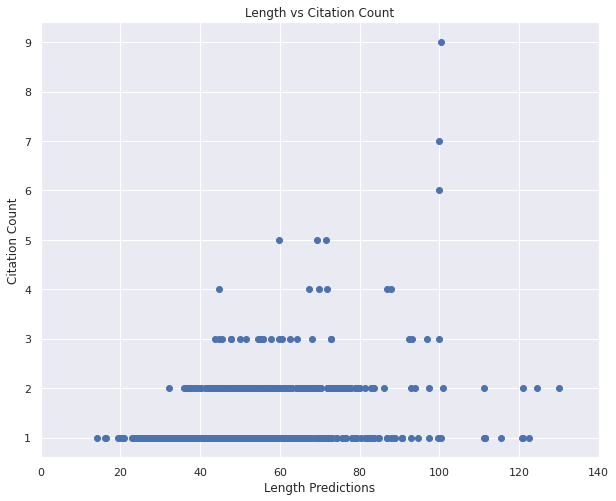

In [357]:
plt.scatter(
    len_data.length_prediction.values, 
    len_data.citation_count.values
)
plt.xlim(0, 140)
plt.xlabel("Length Predictions")
plt.ylabel("Citation Count")
plt.title("Length vs Citation Count")

Text(0.5, 1.0, 'Length vs Citation Count')

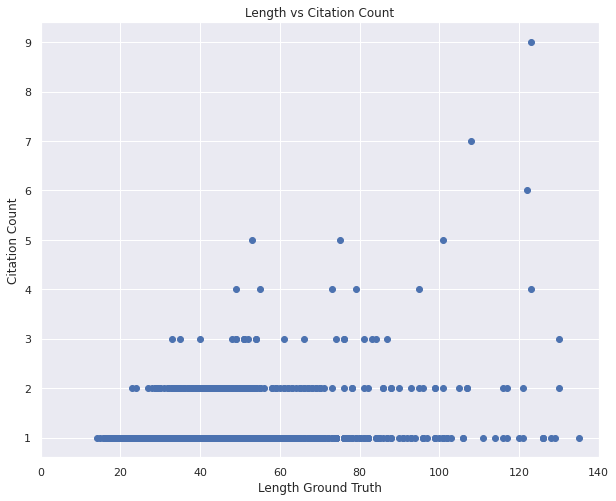

In [356]:
plt.scatter(
    len_data.length_target.values, 
    len_data.citation_count.values,
)
plt.xlim(0, 140)
plt.xlabel("Length Ground Truth")
plt.ylabel("Citation Count")
plt.title("Length vs Citation Count")

In [143]:
abs(len_data.random_sample_length - len_data.length_target).mean()

20.17510986328125

In [144]:
abs(len_data.length_prediction - len_data.length_target).mean()

13.981658935546875

Text(0, 0.5, 'length error')

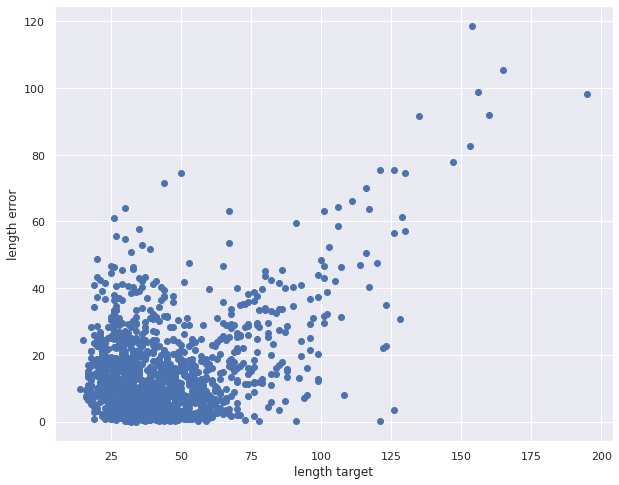

In [359]:
plt.scatter(len_data.length_target.values, len_data.length_error.values )
plt.xlabel("length target")
plt.ylabel("length error")

In [125]:
len_data.corr()

,length_prediction,length_target,context_mean_sentence_length,context_length,length_error,cited_paper_content_length,cited_paper_sentence_mean_length,random_sample_length
length_prediction,1.000000,0.477367,0.007250,-0.063373,0.450749,-0.034763,-0.012470,0.011597
length_target,0.477367,1.000000,-0.023908,-0.038366,0.434346,-0.031043,-0.014167,0.044991
context_mean_sentence_length,0.007250,-0.023908,1.000000,0.433102,0.007080,-0.009042,0.004035,0.031682
context_length,-0.063373,-0.038366,0.433102,1.000000,-0.041223,-0.019726,-0.010827,0.041074
length_error,0.450749,0.434346,0.007080,-0.041223,1.000000,-0.030863,-0.018436,-0.013662
cited_paper_content_length,-0.034763,-0.031043,-0.009042,-0.019726,-0.030863,1.000000,0.557140,-0.028273
cited_paper_sentence_mean_length,-0.012470,-0.014167,0.004035,-0.010827,-0.018436,0.557140,1.000000,-0.037683
random_sample_length,0.011597,0.044991,0.031682,0.041074,-0.013662,-0.028273,-0.037683,1.000000


In [49]:
source_lengths = [len(x["source"]) for x in val_set]

In [51]:
len_data = pd.DataFrame(
    {"length_predictions": length_predictions, 
     "length_targets": lenthg_targets, 
     "source_lengths" : source_lengths }
)

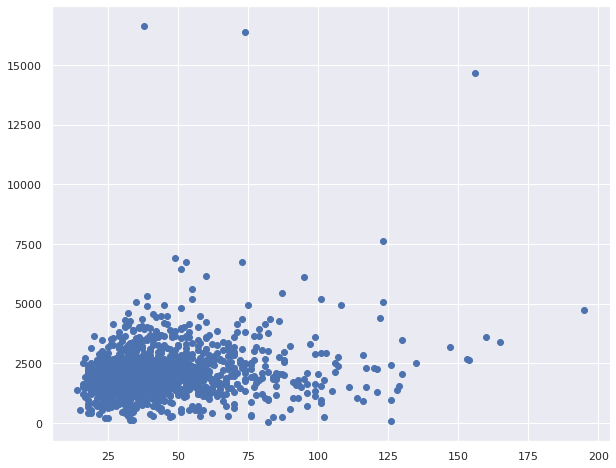

In [54]:
plt.scatter(lenthg_targets, source_lengths)

In [35]:
# i = -1
# i += 1
# print(tokenizer.tokenize(accumulated_data[i]["generated"]).__len__())
# print(length_data[i])
# accumulated_data[i]

In [29]:
len(accumulated_data)

1322

In [36]:
# cit_types = []
# for data in val_set:
#     if "[Dominant]" in data["source"]:
#         cit_types.append("Dominant")
    
#     if "[Reference]" in data["source"]:
#         cit_types.append("Reference")

# list(zip(length_data, cit_types[:len(length_data)]))

In [75]:
analysis_utils.write_json(accumulated_data, os.path.join(path, "../sample_output.json"))

In [29]:
def get_categories(length):
    if length < 10:
        return 1
    elif 10 <= length  < 20:
        return 2
    elif 20 <= length  < 30:
        return 3
    elif 30 <= length  < 40:
        return 4
    elif 40 <= length < 50:
        return 5
    
    return 6

In [30]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [60]:
tar_lengths = [get_categories(l) for _, l in length_data]

In [61]:
target_pred_diff = [y - x for x, y in  length_data]
diff_category_dict = defaultdict(list)
for tar_len, diff in zip(tar_lengths, target_pred_diff):
    diff_category_dict[tar_len].append(diff)

In [62]:
# plt.boxplot(diff_category_dict.values())

In [63]:
pred_lengths = [get_categories(l) for l, _ in length_data]

In [64]:
accuracy_score(tar_lengths, pred_lengths)

0.4394904458598726

In [65]:
print(classification_report(tar_lengths, pred_lengths))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.89      0.57      0.70       787
           3       0.45      0.42      0.43       776
           4       0.40      0.26      0.32       593
           5       0.16      0.39      0.23       355
           6       0.47      0.51      0.49       466

    accuracy                           0.44      2983
   macro avg       0.40      0.36      0.36      2983
weighted avg       0.52      0.44      0.46      2983



/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [27]:
np.mean(abs( lenthg_targets - length_predictions))

9.835243462956756

In [31]:
rmse(lenthg_targets, length_predictions )

14.365725957407426

### Generated vs Target length

In [69]:
np.mean(abs( lenthg_targets - length_generations))

10.80154207173986

In [70]:
rmse(lenthg_targets, length_generations )

17.316414075856766

### Generation vs Predicted Length

Text(0.5, 1.0, 'Generated - predicted length')

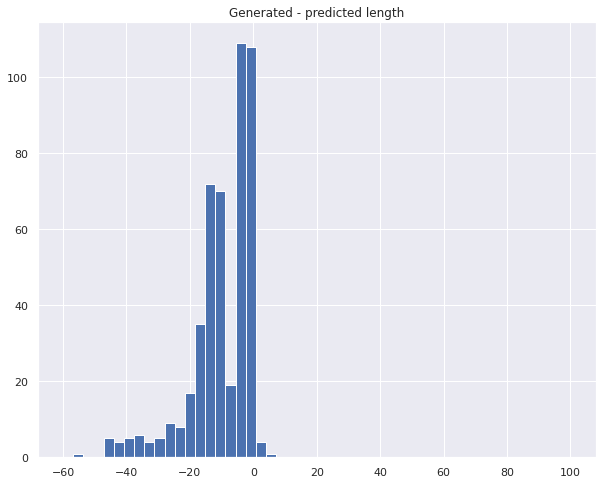

In [42]:
diff = [tokenizer.tokenize(x["generated"]).__len__() - l_pred[0] for x, l_pred in zip(accumulated_data, length_data)]
plt.hist(diff, bins=50, range=(-60,100))
plt.title("Generated - predicted length")
# plt.xlabel("Target span Length - Generated span length.")

In [44]:
np.mean(diff)

-13.44845007123701

In [82]:
print(confusion_matrix(tar_lengths, pred_lengths))

[[  1   2   3   0   0   0]
 [  1 655 107  19   5   0]
 [  0  91 305 216 142  22]
 [  0   6  69 203 220  95]
 [  0   1  18  79 111 146]
 [  0   0   4  51 142 269]]


In [42]:
# accumulated_data[4]

In [43]:
def get_length_difference(data, tokenizer=tokenizer):
    """"""
    return tokenizer.tokenize(data["target"]).__len__() - tokenizer.tokenize(data["generated"]).__len__()
    

In [29]:
old_accumulated_data = copy.deepcopy(accumulated_data)

Text(0.5, 0, 'Target span Length - Generated span length.')

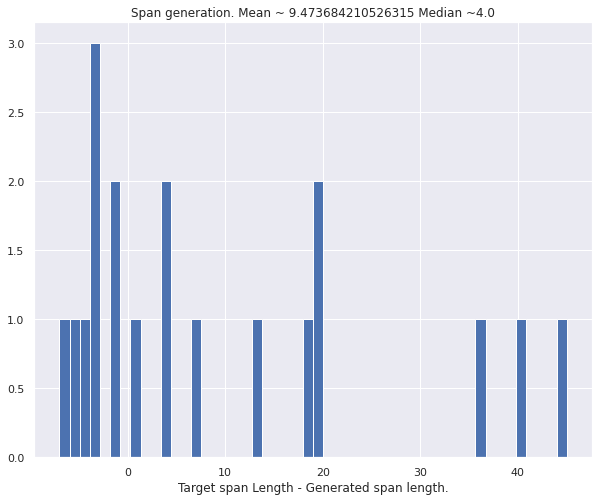

In [44]:
diff = [get_length_difference(x) for x in accumulated_data]
plt.hist(diff, bins=50)
plt.title("Span generation. Mean ~ {} Median ~{}".format(
    sum(diff)/len(diff), np.median(diff)))
plt.xlabel("Target span Length - Generated span length.")

(array([2., 3., 2., 3., 4., 2., 1., 0., 0., 2.]),
 array([ 9. , 16.2, 23.4, 30.6, 37.8, 45. , 52.2, 59.4, 66.6, 73.8, 81. ]),
 <BarContainer object of 10 artists>)

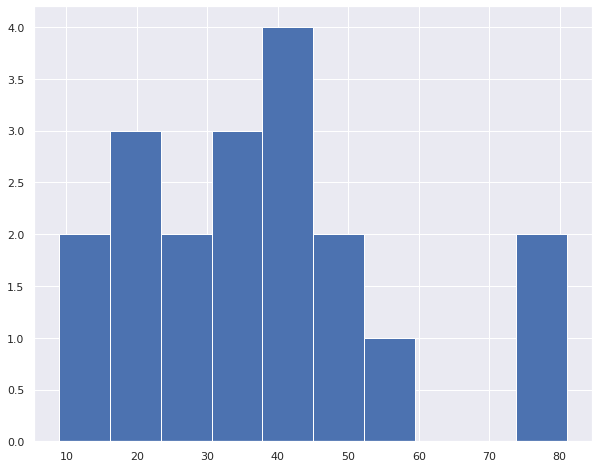

In [47]:
plt.hist([tokenizer.tokenize(x["target"]).__len__() for x in accumulated_data])

In [89]:
accumulated_data[0]

{'source': 'A simple (and yet effective) baseline for zero-shot translation is pivoting that chain-translates, first to a pivot language, then to a target (Cohn and Lapata, 2007; Wu and Wang, 2007; Utiyama and Isahara, 2007) .\nDespite being a pipeline, pivoting gets better as the supervised models improve, which makes it a strong baseline in the zero-shot setting.\nCheng et al. (2017) proposed a joint pivoting learning strategy that leads to further improvements.\nLu et al. (2018) and Arivazhagan et al. (2018) proposed different techniques to obtain "neural interlingual" representations that are passed to the decoder.\n [Dominant] \n\n [B_Dominant] Sestorain et al. (2018) </s> [E_Dominant] [B_Dominant] (He et al., 2016) </s> Dual Learning for Machine Translation | While neural machine translation (NMT) is making good progress in the past two years, tens of millions of bilingual sentence pairs are needed for its training. However, human labeling is very costly. To tackle this training 

In [29]:
# ### Check embedding

# embed = SinusoidalPositionalEmbedding(
#     embedding_dim=model.config.d_model,
#     padding_idx=model.led.decoder.padding_idx,
#     init_size=model.led.decoder.max_target_positions,
#     sinpostype = "ratio"
# )

# input_shape = torch.tensor([1, 50])

# length = torch.tensor([150])

# positions = embed(
#     input_shape = input_shape, 
#     length=length, 
# )

# a = torch.tensor([1,2,3,4])

# t = torch.tensor([7,8,9])

# a.masked_scatter(torch.tensor([True, True, True, False]), t)

In [47]:
# i= 0
# i += 1
# accumulated_data[i]

### ROUGE SCORE

In [37]:
rouge = load_metric("rouge")

In [38]:
dominant_data, reference_data = analysis_utils.split_data_by_citation_type(accumulated_data)

In [39]:
analysis_utils.remove_citation_from_sentence(accumulated_data[0]["target"], accumulated_data[0]["source"])

' proposed another fine-tuning technique that uses dual learning   where a language model is used to provide a signal for fine-tuning zero-shot directions'

In [40]:
analysis_utils.get_citations(accumulated_data[0]["source"])

['Sestorain et al. (2018)', '(He et al., 2016)']

In [41]:
accumulated_data[0]["source"]

'A simple (and yet effective) baseline for zero-shot translation is pivoting that chain-translates, first to a pivot language, then to a target (Cohn and Lapata, 2007; Wu and Wang, 2007; Utiyama and Isahara, 2007) .\nDespite being a pipeline, pivoting gets better as the supervised models improve, which makes it a strong baseline in the zero-shot setting.\nCheng et al. (2017) proposed a joint pivoting learning strategy that leads to further improvements.\nLu et al. (2018) and Arivazhagan et al. (2018) proposed different techniques to obtain "neural interlingual" representations that are passed to the decoder.\n [Dominant] \n\n [B_Dominant] Sestorain et al. (2018) </s> [E_Dominant] [B_Dominant] (He et al., 2016) </s> Dual Learning for Machine Translation | While neural machine translation (NMT) is making good progress in the past two years, tens of millions of bilingual sentence pairs are needed for its training. However, human labeling is very costly. To tackle this training data bottle

In [42]:
predicted = [analysis_utils.remove_citation_from_sentence(x["generated"], x["source"]) for x in accumulated_data]

reference = [analysis_utils.remove_citation_from_sentence(x["target"], x["source"]) for x in accumulated_data]

In [43]:
dominant_predicted = [analysis_utils.remove_citation_from_sentence(x["generated"], x["source"]) for x in dominant_data]

dominant_reference = [analysis_utils.remove_citation_from_sentence(x["target"], x["source"]) for x in dominant_data]

In [44]:
reference_predicted = [analysis_utils.remove_citation_from_sentence(x["generated"], x["source"]) for x in reference_data]

reference_reference = [analysis_utils.remove_citation_from_sentence(x["target"], x["source"]) for x in reference_data]

In [45]:
new_accumulated_data = accumulated_data

In [46]:
rouge.compute(
    predictions=predicted, 
    references=reference, 
    rouge_types=["rouge1","rouge2","rougeL"],
    use_stemmer = True
)

{'rouge1': AggregateScore(low=Score(precision=0.271358133429492, recall=0.31171515136911593, fmeasure=0.271822994337769), mid=Score(precision=0.2794901080283654, recall=0.3192079637649109, fmeasure=0.278706841409453), high=Score(precision=0.287729427790276, recall=0.32759137035275643, fmeasure=0.2851743532359115)),
 'rouge2': AggregateScore(low=Score(precision=0.06948764987208919, recall=0.08032208809933962, fmeasure=0.0696948369898434), mid=Score(precision=0.07420734569972809, recall=0.08588144952725613, fmeasure=0.07424946690057449), high=Score(precision=0.07900927103180688, recall=0.09160960287688139, fmeasure=0.07900013874591452)),
 'rougeL': AggregateScore(low=Score(precision=0.20305194021629602, recall=0.23858075522283173, fmeasure=0.20577468184015907), mid=Score(precision=0.20926761083641135, recall=0.24526010678415222, fmeasure=0.21104583138233388), high=Score(precision=0.21586544361790905, recall=0.25269305612426846, fmeasure=0.21657030839701755))}

### Changing Desired Length Experiments

In [30]:
def run_model(batch, model, length=None):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=['[Dominant]', '[Reference]'],
        length=length
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    model_kwargs = {'decoder_length' : processed_batch_cuda["length"].unsqueeze(0)}
    predicted_abstract_ids = model.generate(
        processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        **model_kwargs
    )
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=False)
    target = batch["target"]
    return out, target

In [31]:
def run_length_controlled_prediction(
    source, target = "dummy target", length=None
):
    """high level function for length controlled generation"""
    test_data = {"source": source, "target": target, "id": "test_123"}

    test_data_list = [test_data]
    
    for batch in DataLoader(test_data_list, batch_size = 1, shuffle=False):
        out, ta = run_model(
            batch, model,
            length=length
        )
        break
    return out[0]

In [32]:
source = """In the past few years, neural machine translation (NMT) has drawn increasing interests due to its simplicity and promising performance (Bahdanau et al., 2014; Jean et al., 2015; Shen et al., 2016; Vaswani et al., 2017) . The widely used * Corresponding author. sequence-to-sequence (Seq2Seq) framework combined with attention mechanism achieves significant improvement over the traditional statistical machine translation (SMT) models on a variety of language pairs, such as Chinese-English Mi et al., 2016; Vaswani et al., 2017; Cheng et al., 2018) . Under an encoder-decoder architecture, the Seq2Seq framework first encodes the source sentence into a sequence of hidden vectors, and then incrementally predicts the target sentence (Cho et al., 2014a) . Recently, inspired by the success of syntaxbased SMT , researchers propose a range of interesting approaches for exploiting syntax information in NMT models, as syntactic trees could offer long-distance relations in sentences Wu et al., 2017b; Bastings et al., 2017; Hashimoto and Tsuruoka, 2017) . As a straightforward method, tree-structured recurrent neural network (Tree-RNN) can elegantly model the source-side syntax and globally encode the whole trees. Eriguchi et al. (2016) , and show that Tree-RNN can effectively integrate syntaxoriented trees into Seq2Seq NMT models. Regardless of the effectiveness of Tree-RNN, we find that it suffers from a severe low-efficiency problem because of the heterogeneity of different syntax trees, which leads to increasing difficulties for batch computation compared with sequential inputs. Even with deliberate batching method of , our preliminary experiments show that Tree-RNN with gated recurrent unit (GRU) can lead to nearly four times slower performance when it is integrated into a classical Seq2Seq system. To solve the problem, Tree-Linearization is a good alternative for syntax encoding. The main idea is to linearize syntax trees into sequential symbols, and then exploit the resulting sequences as inputs for NMT. propose a depth-first method to traverse a constituent tree, converting it into a sequence of symbols mixed with sentential words and syntax labels. Similarly, Wu et al. (2017b) combine several strategies of tree traversing for dependency syntax integration. In this work, we present an implicit syntax encoding method for NMT, enhancing NMT models by syntax-aware word representations (SAWRs). Figure 1 illustrates the basic idea, where trees are modeled indirectly by sequential vectors extracted from an encoder-decoder dependency parser. On the one hand, the method avoids the structural heterogeneity and thus can be integrated efficiently, and on the other hand, it does not require discrete 1-best tree outputs, alleviating the error propagation problem induced from syntax parsers. Concretely, the vector outputs are extracted from the encoding outputs of the encoder-decoder dependency parser. As shown in Figure 1 , the encoding outputs, denoted as o = o 1 · · · o 6 , are then integrated into Seq2Seq NMT models by directly concatenated with the source input word embeddings after a linear projection. We start with a Seq2Seq baseline with attention mechanism (Bahdanau et al., 2014) for study, following previous studies of the same research line, and then integrate source dependency syntax by SAWRs. We conduct experiments on ChineseEnglish and English-Vietnamese translation tasks, respectively. The results show that our method is very effective in source syntax integration. With source dependency syntax, the performances of Chinese-English and English-Vietnamese translation can be significantly boosted by 1.74 BLEU points and 0.80 BLEU points, respectively. We also compare the method with the representative Tree-RNN and Tree-Linearization approaches of syntax integration, finding that our method is able to achieve larger improvements than the two approaches for both tasks. All the codes are released publicly available at https://github.com/zhangmeishan/SYN4NMT under Apache License 2.0. </s> There have been several studies for NMT using dependency syntax.\nHashimoto and Tsuruoka (2017) propose to combine the head information with sequential words together as source encoder inputs, where their input trees are latent dependency graphs.\nRecently, there are several studies by using convolutional neural structures to represent source dependency trees, where tree nodes are modeled individually (Chen et al., 2017b; Bastings et al., 2017) .\n [Dominant] \nAll these methods require certain extra efforts to encode the source dependency syntax over a baseline Seq2Seq NMT.\n\n [B_Dominant] Wu et al. (2017b) </s> Improved neural machine translation with source syntax | Neural Machine Translation (NMT) based on the encoder-decoder architecture has recently achieved the state-of-the-art performance. Researchers have proven that extending word level attention to phrase level attention by incorporating source-side phrase structure can enhance the attention model and achieve promising improvement. However, word dependencies that can be crucial to correctly understand a source sentence are not always in a consecutive fashion (i.e. phrase structure), sometimes they can be in long distance. Phrase structures are not the best way to explicitly model long distance dependencies. In this paper we propose a simple but effective method to incorporate source-side long distance dependencies into NMT. Our method based on dependency trees enriches each source state with global dependency structures, which can better capture the inherent syntactic structure of source sentences. Experiments on Chinese-English and English-Japanese translation tasks show that our proposed method outperforms state-of-the-art SMT and NMT baselines. [E_Dominant]"""

In [51]:
with open(os.path.abspath(os.path.join(path, "../sample_output.json")), 'w') as f:
    json.dump(new_accumulated_data, f)

In [52]:
# with open(os.path.abspath(os.path.join(path, "../sample_output.json")), 'r') as f:
#     accumulated_data = json.loads(f.read())

### Run Text Generation on single datapoint - Exploration

In [22]:
source = """Several approaches have been proposed recently to connect the rich expressiveness of contextualized word embeddings with cross-lingual transfer.\n [Dominant] \nLample and Conneau (2019) adapted the objectives of BERT (Devlin et al., 2018) to incorporate cross-lingual supervision from parallel data to learn cross-lingual language models (XLMs), which have obtained state-of-the-art results on several cross-lingual tasks.\nSimilar to our approach, Schuster et al. (2019) also aligned pretrained contextualized word embeddings through linear transformation in an off-line fashion.\nThey used the averaged contextualized embeddings as an anchor for each word type, and learn a transformation in the anchor space.\nOur approach, however, learns this transformation directly in the contextual space, and hence is explicitly designed to be word sense-preserving.\n\n [B_Dominant] Shen et al. (2016) </s> Minimum Risk Training for Neural Machine Translation | We propose minimum risk training for end-to-end neural machine translation. Unlike conventional maximum likelihood estimation, minimum risk training is capable of optimizing model parameters directly with respect to arbitrary evaluation metrics, which are not necessarily differentiable. Experiments show that our approach achieves significant improvements over maximum likelihood estimation on a state-of-the-art neural machine translation system across various languages pairs. Transparent to architectures, our approach can be applied to more neural networks and potentially benefit more NLP tasks. [E_Dominant]"""

In [23]:
target = "Shen et al. (2019) proposed ml-VAE-D with multi-level latent variables."

In [24]:
def get_generation(gen_model, source):
    test_data = {"source": source, "target": "target 123", "id": "test_123"}

    test_data_list = [test_data]
    for batch in DataLoader(test_data_list, batch_size = 1, shuffle=False):
        out, ta = run_model(batch, gen_model)
        break
    return out[0]

In [25]:
get_generation(model, source)

/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


'</s><s>Shen et al. (2016) proposed to train an end-to-end neural machine translation system with a minimum risk objective, where the objective is to maximize the BLEU score of the final translation model.</s>'

In [32]:
cited_paper = """[B_Dominant] Michel and Neubig (2018) </s> Extreme Adaptation for Personalized Neural Machine Translation | Every person speaks or writes their own flavor of their native language, influenced by a number of factors: the content they tend to talk about, their gender, their social status, or their geographical origin. When attempting to perform Machine Translation (MT), these variations have a significant effect on how the system should perform translation, but this is not captured well by standard one-sizefits-all models. In this paper, we propose a simple and parameter-efficient adaptation technique that only requires adapting the bias of the output softmax to each particular user of the MT system, either directly or through a factored approximation. Experiments on TED talks in three languages demonstrate improvements in translation accuracy, and better reflection of speaker traits in the target text. [E_Dominant]"""

In [34]:
for i in range(0, len(val_set), 20):
    ddd = val_set[i]
    source = get_context(ddd["source"]) + "\n\n" + cited_paper
    try:
        print(get_generation(model, source))
    except:
        pass
    print("\n\n")

/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


</s><s>Michel and Neubig (2018) proposed an extreme adaptation technique that only requires parameter-efficient adaptation of the output softmax to each individual speaker's native language.</s>



</s><s>Michel and Neubig (2018) suggest an extreme adaptation approach for NMT</s>



</s><s>Michel and Neubig (2018) use an adversarial training technique that only requires adapting the bias of the output softmax to each target user.</s>



</s><s>Michel and Neubig (2018) propose a parameter-efficient adaptation technique that only requires the bias of the output softmax.</s>



</s><s>of multi-turn conversation models, Michel and Neubig (2018) proposed an extreme adaptation technique that only requires adapting the bias of the output softmax to each individual user's profile.</s>



</s><s>Michel and Neubig (2018) propose an extreme adaptation technique that only requires the output softmax to be factored.</s>



</s><s>Michel and Neubig (2018) propose an extreme adaptation technique that

</s><s>Michel and Neubig (2018) pointed out that NMT systems are not able to robustly handle the level of linguistic variation in the domain of social media.</s>



</s><s>Michel and Neubig (2018) assess VQA models on TED talks for robustness</s>



</s><s>Michel and Neubig (2018) proposed to extract context from the input by a copy mechanism.</s>



</s><s>Michel and Neubig (2018) have shown that the syntax-agnostic approach is superior to the rule-based approach.</s>



</s><s>Michel and Neubig (2018) proposed an extreme adaptation technique that only requires adapting the output softmax to each speaker of the MT system.</s>



</s><s>Michel and Neubig (2018) show how to adapt a parameter-efficient adaptation technique that does not require parameter training to fit the speaker's profile.</s>



</s><s>Michel and Neubig (2018) propose an adaptation technique that only requires adapting the bias of the output softmax to each particular user of the MT system.
They also report that the 

In [85]:
""

''

In [286]:
tt = [1,2,3,4,5,6]

In [287]:
tt.pop(2)

3

In [288]:
tt

[1, 2, 4, 5, 6]